# Optimisation: Combining multiple error measures

In this example, we show how a weighted sum of errors can be created and minimised using Pints. This problem can arise when some trade-off needs to be found between multiple objectives ([wiki](https://en.wikipedia.org/wiki/Multi-objective_optimization)), which typically leads to hard problems. In time-series modelling, these problems can also arise when there is data available from different experiments on the same system.

To simulate this, we'll load two copies of the [logistic model](../toy/model-logistic.ipynb), and run two simulations with the same parameters (the same system) but different initial conditions (a different experiment).

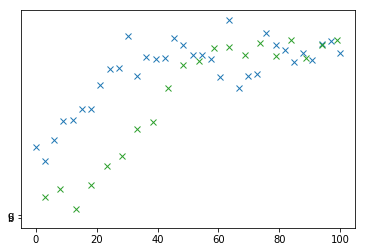

In [2]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Create two models with a different initial population size
model_1 = toy.LogisticModel(initial_population_size=15)
model_2 = toy.LogisticModel(initial_population_size=2)

# Both models share a single set of parameters: it's the same system!
real_parameters = model_1.suggested_parameters()

# The two experiments were sampled at slightly different times
times_1 = model_1.suggested_times()[::3]
times_2 = model_2.suggested_times()[3::5]

experiment_1 = model_1.simulate(real_parameters, times_1)
experiment_2 = model_2.simulate(real_parameters, times_2)

# And both experiments had different noise levels
sigma_1 = 5
experiment_1 += np.random.normal(0, sigma_1, size=times_1.shape)

sigma_2 = 3
experiment_2 += np.random.normal(0, sigma_2, size=times_2.shape)

# Let's have a look!
plt.figure()
plt.plot(times_1, experiment_1, 'x', 'b')
plt.plot(times_2, experiment_2, 'x', 'g')
plt.show()

To solve this, we now create two separate problems and define an error measure on each.

In [3]:
problem_1 = pints.SingleOutputProblem(model_1, times_1, experiment_1)
problem_2 = pints.SingleOutputProblem(model_2, times_2, experiment_2)

error_1 = pints.SumOfSquaresError(problem_1)
error_2 = pints.SumOfSquaresError(problem_2)

Next, we combine the two error functions in a [SumOfErrors](https://pints.readthedocs.io/en/latest/error_measures.html#pints.SumOfErrors).

Note that we have the option to weight the different errors differently, for example to account for a different magnitude of the recoding in different experiments, or to compensate for different numbers of samples.

In [4]:
error = pints.SumOfErrors((error_1, error_2))

Now that we have an error function, we proceed as usual:

In [5]:
opt = pints.Optimisation(error, [1, 40])
opt.set_log_to_screen(False)
x, f = opt.run()
print(x)

[ 0.10140031 50.35153069]


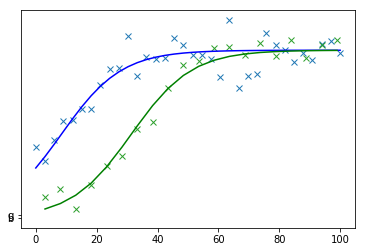

In [6]:
# Now inspect the results
plt.figure()
plt.plot(times_1, experiment_1, 'x', 'b')
plt.plot(times_2, experiment_2, 'x', 'g')
plt.plot(times_1, problem_1.evaluate(x), 'b')
plt.plot(times_2, problem_2.evaluate(x), 'g')
plt.show()